# Cirrhosis Predictor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [3]:
data = pd.concat([train, test])
data.set_index('id', inplace=True)
data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


## Data Cleaning/Wrangling:

No NANS due to (given data - not me):
1. Drop all the rows where miss value (NA) were present in the Drug column
2. Impute missing values with mean results
3. One-hot encoding for all category attributes

In [4]:
data.isna().sum()

N_Days              0
Drug                0
Age                 0
Sex                 0
Ascites             0
Hepatomegaly        0
Spiders             0
Edema               0
Bilirubin           0
Cholesterol         0
Albumin             0
Copper              0
Alk_Phos            0
SGOT                0
Tryglicerides       0
Platelets           0
Prothrombin         0
Stage               0
Status           5271
dtype: int64

- Test set doesn't have its status column (competition determines whether you did good on test set)

Converting Age from days to years:

In [5]:
data['Age'] = data['Age'] / 365.0

Converting appropriate columns to booleans:

In [6]:
to_bool = {   
    'Y':True, 
    'N':False
}

data['Ascites']      = data['Ascites'].map(to_bool)
data['Hepatomegaly'] = data['Hepatomegaly'].map(to_bool)
data['Spiders']      = data['Spiders'].map(to_bool)

In [7]:
data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,58.991781,M,False,False,False,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,52.704110,F,False,False,False,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,37.608219,F,False,True,True,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,50.575342,F,False,False,False,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,45.638356,F,False,True,False,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


## Descriptive Analysis:

In [8]:
data.shape

(13176, 19)

In [9]:
data.columns

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status'],
      dtype='object')

In [10]:
data.dtypes

N_Days             int64
Drug              object
Age              float64
Sex               object
Ascites             bool
Hepatomegaly        bool
Spiders             bool
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
dtype: object

In [11]:
data.drop(columns={'Stage'}).describe()
# Stage = categorical

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
count,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000
mean,2033.583030,50.473962,2.596847,351.331815,3.544221,84.222416,1814.540225,114.197725,115.318534,264.746812,10.630823
std,1091.249998,9.978656,3.828640,197.413677,0.349706,76.558760,1916.383653,48.861248,52.557379,87.511668,0.786116
min,41.000000,26.295890,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000
25%,1234.000000,42.772603,0.700000,248.000000,3.350000,39.000000,824.000000,75.950000,84.000000,210.000000,10.000000
50%,1874.000000,51.284932,1.100000,299.000000,3.580000,63.000000,1166.000000,106.950000,104.000000,264.000000,10.600000
75%,2689.000000,56.668493,3.000000,390.000000,3.770000,102.000000,1840.000000,137.950000,139.000000,316.000000,11.000000
max,4795.000000,78.493151,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000


## EDA:

Correlation Matrix:

In [12]:
numeric_feats = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
corr = data[numeric_feats].corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan

(corr
    .style
    .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
    .highlight_null(color='f1f1f1')
    .format(precision=2)
)

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
N_Days,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Age,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bilirubin,-0.34,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan
Cholesterol,-0.14,-0.06,0.31,nan,nan,nan,nan,nan,nan,nan,nan
Albumin,0.26,-0.11,-0.30,-0.09,nan,nan,nan,nan,nan,nan,nan
Copper,-0.28,0.09,0.44,0.17,-0.23,nan,nan,nan,nan,nan,nan
Alk_Phos,-0.02,0.02,0.13,0.13,-0.09,0.13,nan,nan,nan,nan,nan
SGOT,-0.23,-0.02,0.36,0.34,-0.21,0.33,0.13,nan,nan,nan,nan
Tryglicerides,-0.18,0.02,0.32,0.28,-0.11,0.28,0.10,0.15,nan,nan,nan
Platelets,0.14,-0.10,-0.08,0.09,0.14,-0.10,0.04,-0.04,0.02,nan,nan


- No strong linear correlation, but Bilirubin has relatively the strongest correlation w/ other variables

Distribution of Status:

,count
Status,
C,4965
D,2665
CL,275


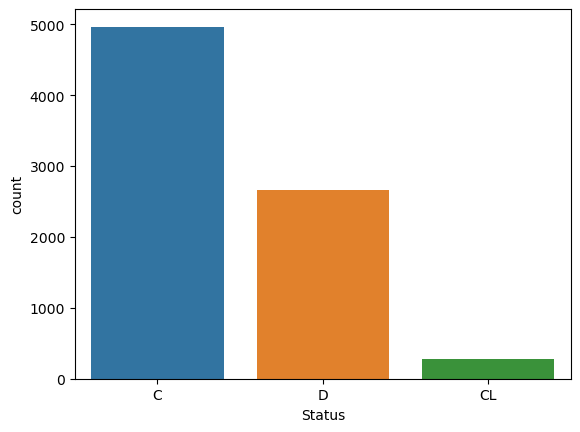

In [13]:
status = data[['Status']].value_counts().reset_index()

sns.barplot(status, 
            x='Status',
            y='count');
status.set_index('Status')

- Significant class imbalance between the 3 labels

Histograms for all quantitative variables (includes Stage):

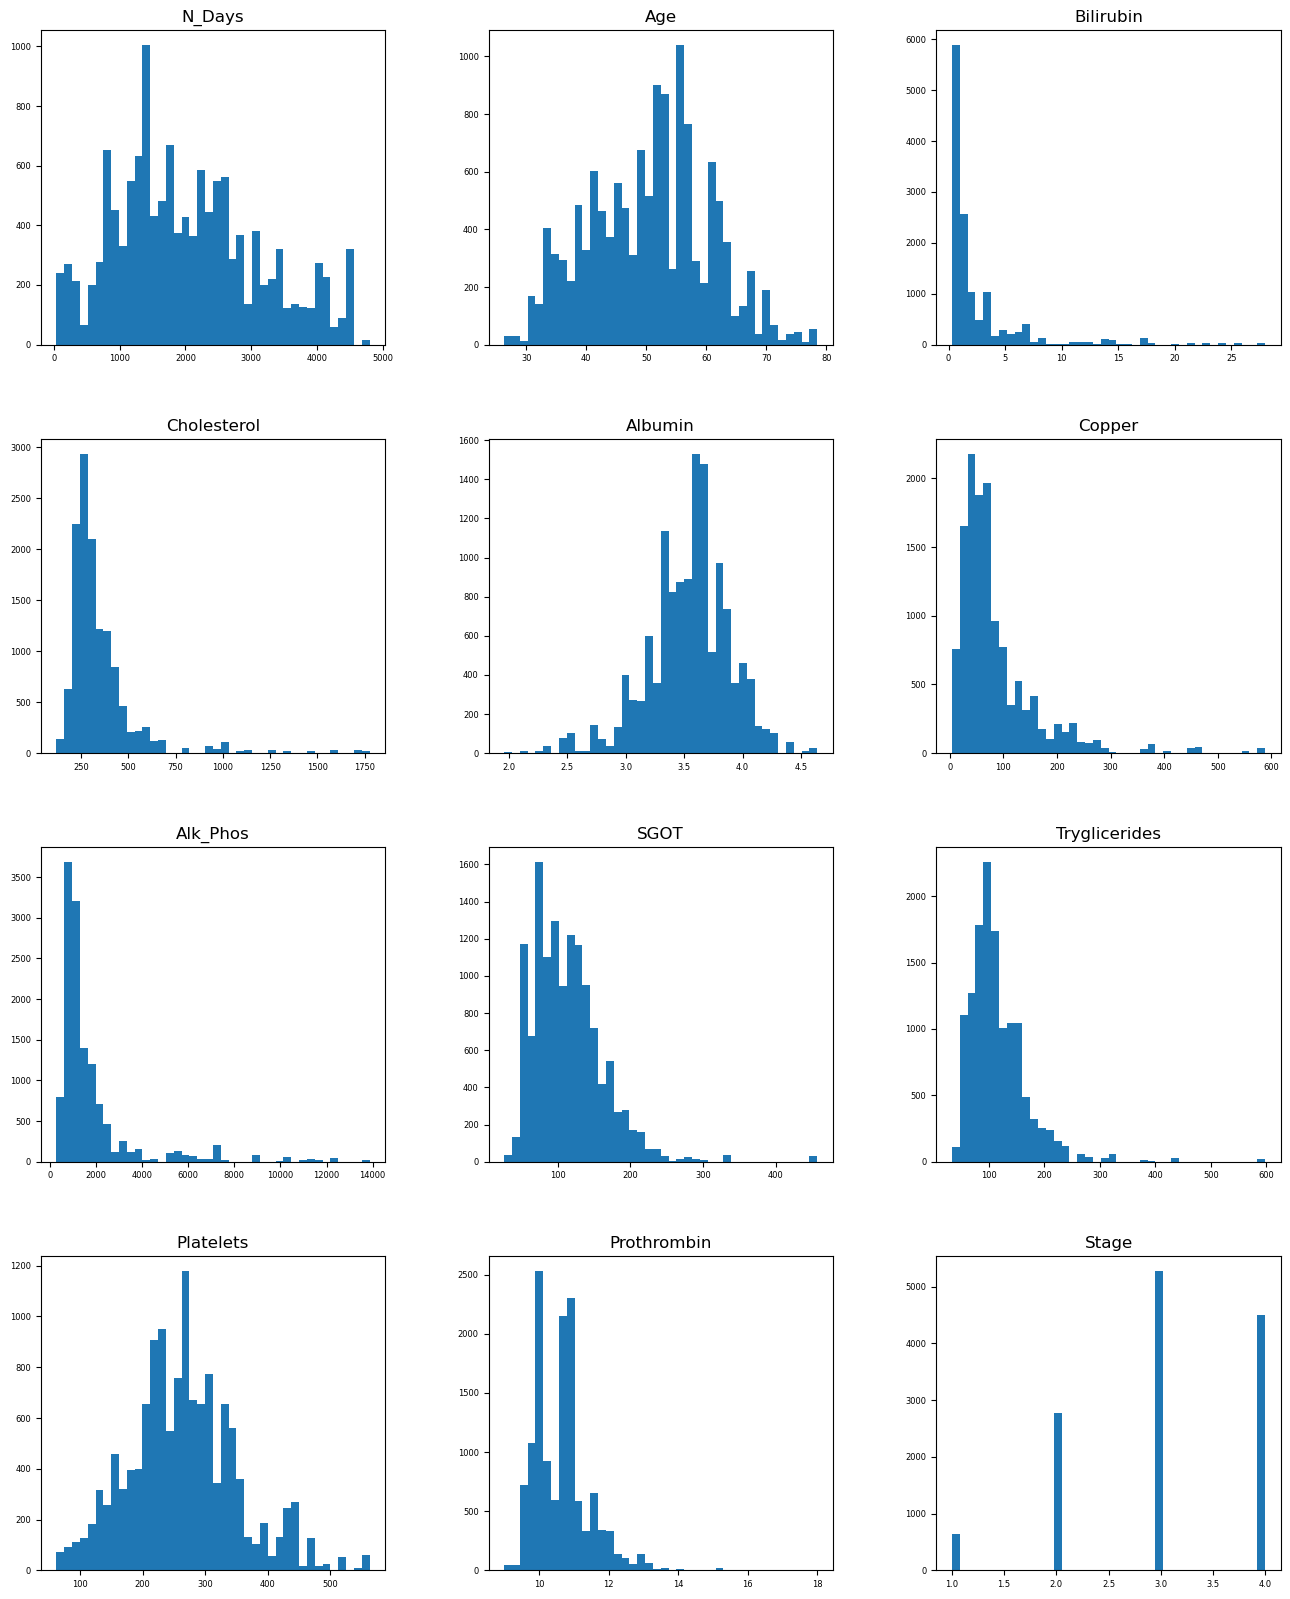

In [14]:
ax = data.hist(figsize=(16, 20), 
               bins=40, 
               xlabelsize=6, 
               ylabelsize=6);

for row in ax:
    for subplot in row:
        subplot.grid(False)

## Predictive Analysis:

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

Splitting the train set into training, validation, and test sets:

In [16]:
train = data.copy()
test  = train[train.Status.isna()].drop(columns={'Status'})
train = train[train.Status.notna()]

data_X = train.drop(columns={'Status'})
data_Y = train.Status

X, test_X, Y, test_Y = train_test_split(
    data_X, data_Y,
    test_size=.2, random_state=42069
)

train_X, val_X, train_Y, val_Y = train_test_split(
    X, Y,
    test_size=.25, random_state=42069
)

### Baseline Model:

In [17]:
categorical = ['Sex', 'Drug', 'Edema', 'Stage']
bools = ['Ascites', 'Hepatomegaly', 'Spiders']       
std = ['N_Days', 'Age', 'Albumin', 'Platelets']
log_std = ['Bilirubin', 'SGOT', 'Tryglicerides', 'Prothrombin', 'Cholesterol', 'Copper', 'Alk_Phos']

categorical_transformer = Pipeline(
    steps=
    [
        ('one hot encode', OneHotEncoder())
    ]
)

std_transformer = Pipeline(
    steps=
    [
        ('standardization', StandardScaler())
    ]
)


log_std_transformer = Pipeline(
    steps=
    [
        ('log', FunctionTransformer(np.log)),
        ('standardization', StandardScaler())
    ]
)


preproc_base = ColumnTransformer(
    transformers =
    [
        ('bools', 'passthrough', bools),
        ('one hot encode', categorical_transformer, categorical),
        ('standardize', std_transformer, std),
        ('log std', log_std_transformer, log_std)
    ],
    remainder='drop'
)

base_pl = Pipeline(
    [
        ('preprocessor', preproc_base),
        ('rfc', RandomForestClassifier(
                random_state=69,
                class_weight='balanced',
                criterion='entropy',
                max_features='sqrt'
            )
        )
    ]
)

Fitting baseline model onto training set:

In [18]:
base_pl.fit(train_X, train_Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bools', 'passthrough',
                                                  ['Ascites', 'Hepatomegaly',
                                                   'Spiders']),
                                                 ('one hot encode',
                                                  Pipeline(steps=[('one hot '
                                                                   'encode',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Drug', 'Edema',
                                                   'Stage']),
                                                 ('standardize',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['N_Days', 'Age', 'Albumin',
                                                   'Platelets']),
                                                 ('log std',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardization',
                                                                   StandardScaler())]),
                                                  ['Bilirubin', 'SGOT',
                                                   'Tryglicerides',
                                                   'Prothrombin', 'Cholesterol',
                                                   'Copper', 'Alk_Phos'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        random_state=69))])

In [19]:
from sklearn.model_selection import GridSearchCV
hyperparams = {
    'rfc__criterion'   : ['gini', 'entropy'],
    'rfc__max_features': ['sqrt', 'log2', None],
    'rfc__class_weight': ['balanced'],
}

# grid_search = GridSearchCV(base_pl, hyperparams, scoring='neg_log_loss')
# grid_search.fit(train_X, train_Y)
# print(grid_search.best_params_)

# Result: {'rfc__class_weight': 'balanced', 'rfc__criterion': 'entropy', 'rfc__max_features': 'sqrt'}

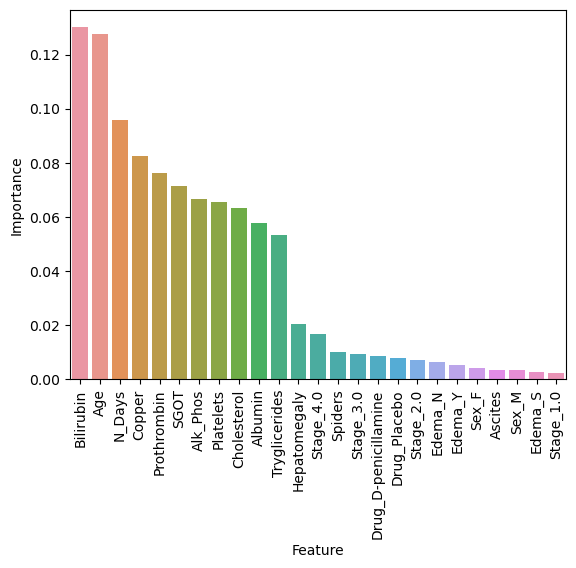

In [20]:
feat_importances = base_pl.named_steps['rfc'].feature_importances_

# Get the names of the features after preprocessing
feature_names = preproc_base.transformers_[1][1]['one hot encode'].get_feature_names_out(categorical).tolist()
feature_names = bools + feature_names + std + log_std

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feat_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
feat_fig = sns.barplot(data=feature_importance_df,
                       x='Feature', 
                       y='Importance');
feat_fig.set_xticklabels(labels=feature_importance_df.Feature, rotation=90);

In [21]:
base_pl_predicted_train_Y = base_pl.predict(train_X)
base_pl_predicted_val_Y   = base_pl.predict(val_X)
base_pl_predicted_test_Y  = base_pl.predict(test_X)

In [22]:
print(classification_report(train_Y.values.flatten(), base_pl_predicted_train_Y))

              precision    recall  f1-score   support

           C       1.00      1.00      1.00      2978
          CL       1.00      1.00      1.00       170
           D       1.00      1.00      1.00      1595

    accuracy                           1.00      4743
   macro avg       1.00      1.00      1.00      4743
weighted avg       1.00      1.00      1.00      4743



In [23]:
print(classification_report(val_Y.values.flatten(), base_pl_predicted_val_Y))

              precision    recall  f1-score   support

           C       0.83      0.94      0.88      1007
          CL       0.86      0.16      0.27        38
           D       0.83      0.68      0.75       536

    accuracy                           0.83      1581
   macro avg       0.84      0.59      0.63      1581
weighted avg       0.83      0.83      0.82      1581



In [24]:
print(classification_report(test_Y.values.flatten(), base_pl_predicted_test_Y))

              precision    recall  f1-score   support

           C       0.84      0.93      0.88       980
          CL       0.75      0.09      0.16        67
           D       0.81      0.73      0.77       534

    accuracy                           0.83      1581
   macro avg       0.80      0.58      0.60      1581
weighted avg       0.82      0.83      0.81      1581



In [25]:
base_pl_predicted_train_Y = base_pl.predict_proba(train_X)
base_pl_predicted_val_Y   = base_pl.predict_proba(val_X)
base_pl_predicted_test_Y  = base_pl.predict_proba(test_X)

(
    log_loss(train_Y.values.flatten(), base_pl_predicted_train_Y), 
    log_loss(val_Y.values.flatten(), base_pl_predicted_val_Y),
    log_loss(test_Y.values.flatten(), base_pl_predicted_test_Y)
)

(0.11747433899268925, 0.5020654427778326, 0.5438655528887659)

Reflection of Baseline Model:
- Used all variables
- One hot encoded all categorical features
- Standardized all the roughly normal distributed variables
- Log transformed - then standardized - all right skewed variables

Model obviously overfit training set. The log loss metric was low, but was higher on validation and test sets.
- Lower amount of features
- Address class inbalance:
    - Oversample to support the minority classes in the training set, or
    - Undersample the majority class

## PCA:
- Assumptions:
    - Only quantitative features
    - Data is standardized

In [26]:
from sklearn.decomposition import PCA

In [27]:
std = ['N_Days', 'Age', 'Albumin', 'Platelets']
log_std = ['Bilirubin', 'SGOT', 'Tryglicerides', 'Prothrombin', 'Cholesterol', 'Copper', 'Alk_Phos']

preproc_base = ColumnTransformer(
    transformers =
    [
        ('standardize', std_transformer, std),
        ('log std', log_std_transformer, log_std)
    ],
    remainder='drop'
)

pca_base_pl = Pipeline(
    [
        ('preprocessor', preproc_base),
        ('rfc', RandomForestClassifier(
                random_state=69,
                class_weight='balanced',
                criterion='entropy',
                max_features='sqrt'
            )
        )
    ]
)

pca_base_pl.fit(data_X[numeric_feats], data_Y)
transformed_data = pca_base_pl.named_steps['preprocessor'].transform(data)

# Convert the transformed data array to a DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=std + log_std)

# Concatenate the transformed DataFrame with the remaining columns from the original DataFrame
final_transformed_df = pd.concat([transformed_df, data.drop(columns=std + log_std)], axis=1)

Fitting PCA on the transformed numeric features:

In [28]:
PCA_base = PCA(random_state=69)
PCA_base.fit(transformed_df)

PCA(random_state=69)

Scree Plot:

[3.10944047 1.49450214 0.95459988 0.91734399 0.83008023 0.77713126
 0.76597264 0.67834326 0.63013987 0.49348749 0.38559968]


[-1.61493833 -0.53990227 -0.03725588 -0.08726376 -0.05294898 -0.01115862
 -0.08762938 -0.04820339 -0.13665238 -0.1078878 ]




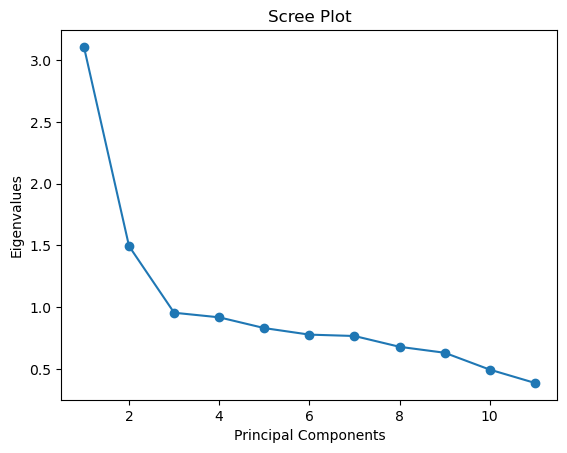

In [29]:
eigenvalues = PCA_base.explained_variance_
print(PCA_base.explained_variance_)
print('\n')
print(np.ediff1d(eigenvalues))
print('\n')

plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot')
plt.show()

- 2-3 Principal Compnents are optimal, since scree plot starts to drop off around there
    - Will be useful to look at cumulative explained variance too

Cumulative explained variance:

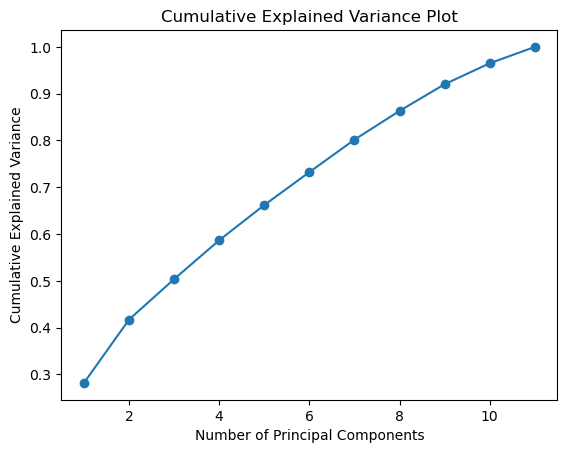

In [30]:
# Cumulative explained variance
cumulative_variance = np.cumsum(PCA_base.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.show()

- Again, 2-3 Principal Components are optimal, since the increase seems to taper off around there

Loadings/Coefficients associated w/ each variable in each PC: 

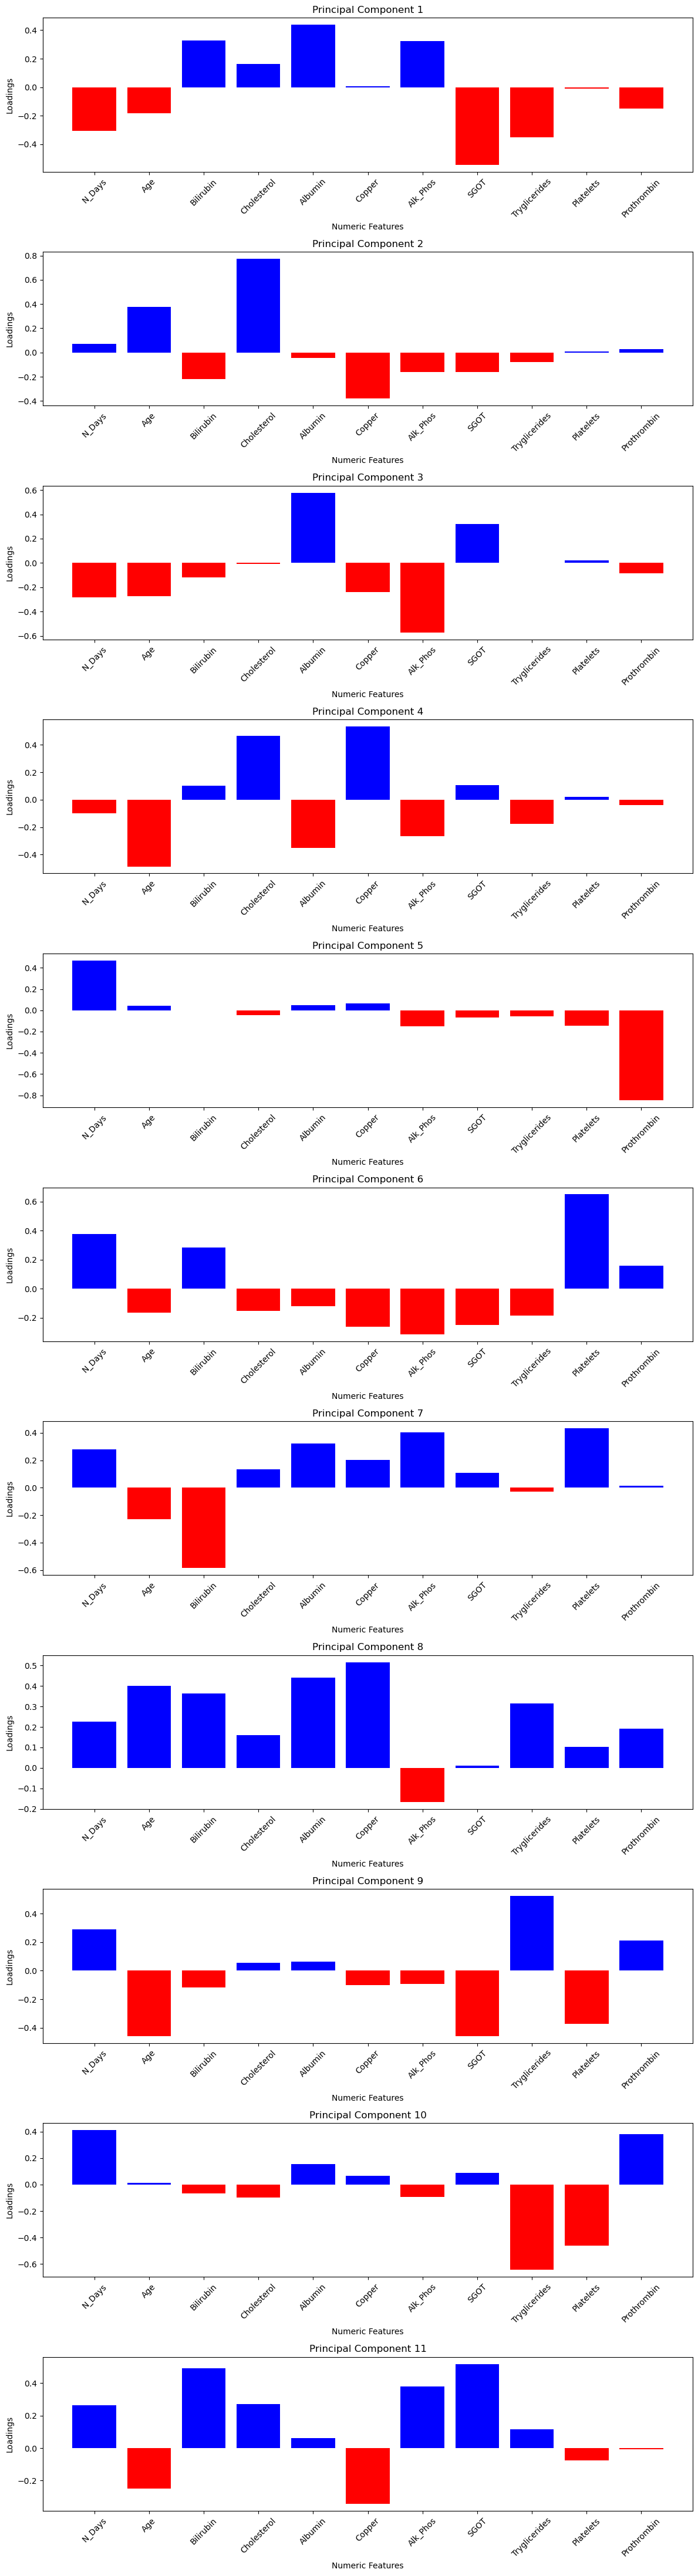

In [31]:
# Access the principal components (eigenvectors):
components = PCA_base.components_

# Create a DataFrame to display the loadings:
loadings_df = pd.DataFrame(components, columns=numeric_feats)

# Transpose the loadings DataFrame for easier plotting
loadings_df_transposed = loadings_df.T

# Set up the figure and axes
fig, axs = plt.subplots(nrows=loadings_df_transposed.shape[0], ncols=1, figsize=(12, 4 * loadings_df_transposed.shape[0]))

# Plot the loadings for all principal components
for i in range(loadings_df_transposed.shape[0]):
    # Set the color based on the sign of the loadings
    colors = ['red' if loadings_df_transposed.iloc[i, j] < 0 else 'blue' for j in range(len(numeric_feats))]
    
    axs[i].bar(range(len(numeric_feats)), loadings_df_transposed.iloc[i], color=colors)
    axs[i].set_title(f'Principal Component {i + 1}')
    axs[i].set_xlabel('Numeric Features')
    axs[i].set_ylabel('Loadings')
    axs[i].set_xticks(range(len(numeric_feats)))
    axs[i].set_xticklabels(numeric_feats, rotation=45)

plt.tight_layout()
plt.show()

### PCA Reflection:
- 2-3 PCs seem to be optimal
- Features that had major influence among the 2-3 PCs
    - 2nd PC:
        1. Cholesterol
        2. Tryglicerides
    - 3rd PC:
        1. Alk_Phos
        2. Prothrombin 

### Addressing Class Imbalance via Oversampling:

- Using SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous) since it can deal w/ both Nominal and Continuous features

In [32]:
from imblearn.over_sampling import SMOTENC

In [33]:
train_oversampled = train.copy()
X = train_oversampled.drop(columns={'Status'})
Y = train_oversampled.Status

smote_tomek = SMOTENC(categorical, random_state=42)
X_train_resampled, Y_train_resampled = smote_tomek.fit_resample(X, Y)

In [34]:
X_train_resampled

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,999,D-penicillamine,58.991781,M,False,False,False,N,2.300000,316.000000,3.350000,172.000000,1601.000000,179.800000,63.000000,394.000000,9.700000,3.0
1,2574,Placebo,52.704110,F,False,False,False,N,0.900000,364.000000,3.540000,63.000000,1440.000000,134.850000,88.000000,361.000000,11.000000,3.0
2,3428,Placebo,37.608219,F,False,True,True,Y,3.300000,299.000000,3.550000,131.000000,1029.000000,119.350000,50.000000,199.000000,11.700000,4.0
3,2576,Placebo,50.575342,F,False,False,False,N,0.600000,256.000000,3.500000,58.000000,1653.000000,71.300000,96.000000,269.000000,10.700000,3.0
4,788,Placebo,45.638356,F,False,True,False,N,1.100000,346.000000,3.650000,63.000000,1181.000000,125.550000,96.000000,298.000000,10.600000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14890,126,Placebo,43.122848,F,True,True,True,N,2.980867,242.321445,3.188304,129.552289,1451.126265,99.440530,184.028916,206.028916,11.258120,4.0
14891,1434,D-penicillamine,49.123158,F,False,True,True,N,2.241347,240.705123,3.849060,59.924163,1891.978620,121.502742,104.981848,268.860024,10.088140,3.0
14892,739,D-penicillamine,60.282911,F,False,True,True,N,1.398153,228.061572,3.767569,225.000000,1060.541561,112.754149,81.006157,132.024629,11.099692,4.0
14893,1400,Placebo,49.613144,F,True,True,True,Y,1.350584,211.897856,3.769767,71.392020,1012.890075,146.459925,67.490274,190.106034,9.600778,4.0


What the oversampling added to the training set:

In [35]:
Y_train_resampled[7905:].value_counts()

Status
CL    4690
D     2300
Name: count, dtype: int64

In [36]:
Y_train_resampled.value_counts()

Status
D     4965
C     4965
CL    4965
Name: count, dtype: int64

### Final Model:

In [37]:
bools       = ['Ascites', 'Hepatomegaly', 'Spiders']       
categorical = ['Drug', 'Sex', 'Edema', 'Stage']
std         = ['N_Days', 'Age', 'Albumin', 'Platelets']
log_std     = ['Bilirubin', 'SGOT', 'Tryglicerides', 'Prothrombin', 'Cholesterol', 'Copper', 'Alk_Phos']

In [38]:
# bools       = ['Ascites', 'Hepatomegaly', 'Spiders']       
# categorical = ['Drug', 'Sex', 'Edema', 'Stage']
std         = ['Age', 'Albumin', 'Platelets']
log_std     = ['Bilirubin', 'Prothrombin', 'Cholesterol', 'Alk_Phos']

preproc_final = ColumnTransformer(
    transformers =
    [
        ('bools', 'passthrough', bools),
        ('one hot encode', categorical_transformer, categorical),
        ('standardize', std_transformer, std),
        ('log std', log_std_transformer, log_std),
    ],
    remainder='drop'
)

final_pl = Pipeline(
    [
        ('preprocessor', preproc_final),
        ('rfc', RandomForestClassifier(
                random_state=69,
                class_weight='balanced',
                criterion='entropy',
                max_features='log2'
            )
        )
    ]
)

In [39]:
final_pl.fit(X_train_resampled, Y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bools', 'passthrough',
                                                  ['Ascites', 'Hepatomegaly',
                                                   'Spiders']),
                                                 ('one hot encode',
                                                  Pipeline(steps=[('one hot '
                                                                   'encode',
                                                                   OneHotEncoder())]),
                                                  ['Drug', 'Sex', 'Edema',
                                                   'Stage']),
                                                 ('standardize',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['Age', 'Albumin',
                                                   'Platelets']),
                                                 ('log std',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardization',
                                                                   StandardScaler())]),
                                                  ['Bilirubin', 'Prothrombin',
                                                   'Cholesterol',
                                                   'Alk_Phos'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features='log2',
                                        random_state=69))])

In [40]:
hyperparams = {
    'rfc__criterion'   : ['gini', 'entropy'],
    'rfc__max_features': ['sqrt', 'log2', None],
    'rfc__class_weight': ['balanced'],
}

# grid_search = GridSearchCV(final_pl, hyperparams, scoring='neg_log_loss')
# grid_search.fit(train_X, train_Y)
# print(grid_search.best_params_)

# Result: {'rfc__class_weight': 'balanced', 'rfc__criterion': 'entropy', 'rfc__max_features': 'log2'}

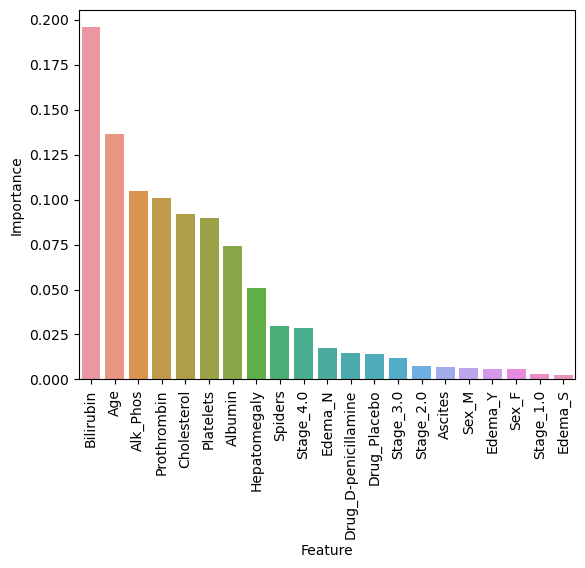

In [41]:
feat_importances = final_pl.named_steps['rfc'].feature_importances_

# Get the names of the features after preprocessing
feature_names = preproc_final.transformers_[1][1]['one hot encode'].get_feature_names_out(categorical).tolist()

feature_names = bools + feature_names + std + log_std

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feat_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
feat_fig = sns.barplot(data=feature_importance_df,
                       x='Feature', 
                       y='Importance');
feat_fig.set_xticklabels(labels=feature_importance_df.Feature, rotation=90);

In [42]:
final_pl_predicted_train_Y = final_pl.predict(train_X)
final_pl_predicted_train_resampled_Y = final_pl.predict(X_train_resampled)

final_pl_predicted_val_Y   = final_pl.predict(val_X)
final_pl_predicted_test_Y  = final_pl.predict(test_X)

In [43]:
print(classification_report(train_Y.values.flatten(), final_pl_predicted_train_Y))

              precision    recall  f1-score   support

           C       1.00      1.00      1.00      2978
          CL       1.00      1.00      1.00       170
           D       1.00      1.00      1.00      1595

    accuracy                           1.00      4743
   macro avg       1.00      1.00      1.00      4743
weighted avg       1.00      1.00      1.00      4743



In [44]:
print(classification_report(Y_train_resampled.values.flatten(), final_pl_predicted_train_resampled_Y))

              precision    recall  f1-score   support

           C       1.00      1.00      1.00      4965
          CL       1.00      1.00      1.00      4965
           D       1.00      1.00      1.00      4965

    accuracy                           1.00     14895
   macro avg       1.00      1.00      1.00     14895
weighted avg       1.00      1.00      1.00     14895



In [45]:
print(classification_report(val_Y.values.flatten(), final_pl_predicted_val_Y))

              precision    recall  f1-score   support

           C       1.00      1.00      1.00      1007
          CL       1.00      1.00      1.00        38
           D       1.00      1.00      1.00       536

    accuracy                           1.00      1581
   macro avg       1.00      1.00      1.00      1581
weighted avg       1.00      1.00      1.00      1581



In [46]:
print(classification_report(test_Y.values.flatten(), final_pl_predicted_test_Y))

              precision    recall  f1-score   support

           C       1.00      1.00      1.00       980
          CL       1.00      1.00      1.00        67
           D       1.00      1.00      1.00       534

    accuracy                           1.00      1581
   macro avg       1.00      1.00      1.00      1581
weighted avg       1.00      1.00      1.00      1581



In [47]:
final_pl_predicted_train_Y = final_pl.predict_proba(train_X)
final_pl_predicted_train_resampled_Y = final_pl.predict_proba(X_train_resampled)

final_pl_predicted_val_Y   = final_pl.predict_proba(val_X)
final_pl_predicted_test_Y  = final_pl.predict_proba(test_X)

(
    log_loss(train_Y.values.flatten(), final_pl_predicted_train_Y), 
    log_loss(Y_train_resampled.values.flatten(), final_pl_predicted_train_resampled_Y), 
    log_loss(val_Y.values.flatten(),   final_pl_predicted_val_Y),
    log_loss(test_Y.values.flatten(),  final_pl_predicted_test_Y)
)

(0.13082902257520723,
 0.10588283352763413,
 0.1296630351178506,
 0.12910962432327283)

Fitting onto all of training data:

In [48]:
base_pl.fit(data_X, data_Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bools', 'passthrough',
                                                  ['Ascites', 'Hepatomegaly',
                                                   'Spiders']),
                                                 ('one hot encode',
                                                  Pipeline(steps=[('one hot '
                                                                   'encode',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Drug', 'Edema',
                                                   'Stage']),
                                                 ('standardize',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['N_Days', 'Age', 'Albumin',
                                                   'Platelets']),
                                                 ('log std',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardization',
                                                                   StandardScaler())]),
                                                  ['Bilirubin', 'SGOT',
                                                   'Tryglicerides',
                                                   'Prothrombin', 'Cholesterol',
                                                   'Copper', 'Alk_Phos'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        random_state=69))])

In [49]:
final_pl.fit(data_X, data_Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bools', 'passthrough',
                                                  ['Ascites', 'Hepatomegaly',
                                                   'Spiders']),
                                                 ('one hot encode',
                                                  Pipeline(steps=[('one hot '
                                                                   'encode',
                                                                   OneHotEncoder())]),
                                                  ['Drug', 'Sex', 'Edema',
                                                   'Stage']),
                                                 ('standardize',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['Age', 'Albumin',
                                                   'Platelets']),
                                                 ('log std',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardization',
                                                                   StandardScaler())]),
                                                  ['Bilirubin', 'Prothrombin',
                                                   'Cholesterol',
                                                   'Alk_Phos'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features='log2',
                                        random_state=69))])

In [50]:
base_pl_predicted_train_Y = base_pl.predict_proba(data_X)
log_loss(data_Y.values.flatten(), base_pl_predicted_train_Y)

0.11356486843608583

In [51]:
final_pl_predicted_train_Y = final_pl.predict_proba(data_X)
log_loss(data_Y.values.flatten(), final_pl_predicted_train_Y)

0.12005764883913222

Probabilities for each class on the individuals in the entire test set:

In [52]:
base_pl.predict_proba(test)

array([[0.74, 0.01, 0.25],
       [0.72, 0.16, 0.12],
       [0.15, 0.02, 0.83],
       ...,
       [0.94, 0.  , 0.06],
       [0.97, 0.03, 0.  ],
       [0.35, 0.06, 0.59]])

In [53]:
final_pl.predict_proba(test)

array([[0.57, 0.04, 0.39],
       [0.85, 0.09, 0.06],
       [0.06, 0.  , 0.94],
       ...,
       [0.91, 0.02, 0.07],
       [0.95, 0.  , 0.05],
       [0.45, 0.  , 0.55]])

In [54]:
submission = pd.DataFrame(base_pl.predict_proba(test))
submission.columns = ['Status_C',	'Status_CL', 'Status_D']
submission['id'] = test.index
submission = submission[['id', 'Status_C',	'Status_CL', 'Status_D']]
submission.set_index('id', inplace=True)
submission

,Status_C,Status_CL,Status_D
id,,,
7905,0.74,0.01,0.25
7906,0.72,0.16,0.12
7907,0.15,0.02,0.83
7908,0.97,0.00,0.03
7909,0.67,0.04,0.29
...,...,...,...
13171,0.66,0.13,0.21
13172,0.92,0.02,0.06
13173,0.94,0.00,0.06


In [55]:
# submission = pd.DataFrame(final_pl.predict_proba(test))
# submission.columns = ['Status_C',	'Status_CL', 'Status_D']
# submission['id'] = test.index
# submission = submission[['id', 'Status_C',	'Status_CL', 'Status_D']]
# submission.set_index('id', inplace=True)
# submission

Competition will score something like this:
- log_loss([correct labels of the test set], final_pl.predict_proba(test))

File to submit to competition:

In [56]:
submission.to_csv('submission.csv')